In [1]:
import numpy as np, os
import matplotlib as mpl
%matplotlib notebook

In [2]:
from matplotlib import pyplot as plt

In [3]:
workdir = '_tmp.explore-random-sampling-big-Qspace-box'
!mkdir -p {workdir}
%cd {workdir}

/home/lj7/dv/mcvine/phonon/tests/phonon/_tmp.explore-random-sampling-big-Qspace-box


In [4]:
from mcvine.phonon.from_phonopy import call_phonopy

In [5]:
supercell = 6,6,1
sc_mat = np.diag(supercell)

In [6]:
graphite_datadir = os.path.abspath('../../data/graphite/')

In [7]:
from phonopy import file_IO
force_constants=file_IO.parse_FORCE_CONSTANTS(os.path.join(graphite_datadir, 'FORCE_CONSTANTS'))

In [8]:
poscar = os.path.join(graphite_datadir, 'POSCAR')

In [9]:
species = ['C']

In [10]:
qpoints = [[0.,0.,0.], [1,0,0], [0,1,0], [0,0,1], [1,1,0], [1,0,1], [0, 1,1], [1,1,1]]

In [11]:
qs, freqs, pols = call_phonopy.onGrid(
    species, qpoints, sc_mat, 
    force_constants = force_constants,
    poscar = poscar,
    freq2omega=1
)

In [12]:
freqs.shape

(8, 12)

In [13]:
freqs[0]

array([  3.34225831e-02,   3.34225831e-02,   9.28652901e-02,
         1.52100901e+00,   1.52100901e+00,   2.61040097e+00,
         2.63887591e+01,   2.65558347e+01,   4.76904068e+01,
         4.76904068e+01,   4.78045328e+01,   4.78045328e+01])

In [14]:
pols.shape

(8, 12, 4, 3)

In [15]:
norms = np.linalg.norm(pols, axis=-1)

In [16]:
pols/=norms[:, :, :, np.newaxis]

In [17]:
pols[0][2]

array([[ -1.38736765e-11+0.j,   8.71603397e-12+0.j,  -1.00000000e+00+0.j],
       [ -1.37925833e-11+0.j,   8.75866422e-12+0.j,  -1.00000000e+00+0.j],
       [ -1.38740305e-11+0.j,   8.71665564e-12+0.j,  -1.00000000e+00+0.j],
       [ -1.37932231e-11+0.j,   8.75860894e-12+0.j,  -1.00000000e+00+0.j]])

In [18]:
cat {poscar}

C
    1.0
       2.44618916393 0.00000000000   0.00000000000           
      -1.22309458197 2.11846195843   0.00000000000
       0.00000000000   0.00000000000 6.65422904762 
  4
Direct
        0.00000000 0.00000000 0.25000000
        0.00000000 0.00000000 0.75000000
        0.33333333 0.66666667 0.25000000
        0.66666667 0.33333333 0.75000000


# random Q points

In [20]:
Q_bins = np.arange(0,22, 0.1)
E_bins = np.arange(0,250, 1.)
bins = Q_bins, E_bins
# max Q of requested Q axis                                                                                                                                                                                                                                                                                     
max_Q = Q_bins[-1]

In [21]:
%%time
N = int(1e7)
N = int(1e6)
Qmag = np.random.rand(N)*max_Q
cos_theta = np.random.rand(N)*2-1  # -1 -- 1
phi = np.random.rand(N) * 2 * np.pi
sin_theta = np.sqrt(1-cos_theta*cos_theta)
sin_phi = np.sin(phi); cos_phi = np.cos(phi)
Qx = Qmag*sin_theta*cos_phi
Qy = Qmag*sin_theta*sin_phi
Qz = Qmag*cos_theta
Qpoints = np.array([Qx,Qy,Qz]).T

CPU times: user 324 ms, sys: 40 ms, total: 364 ms
Wall time: 361 ms


# Cartesian to hkl

In [23]:
from mcvine.phonon import from_phonopy

In [24]:
from_phonopy.make_crystal_xyz('graphite.xyz', species, poscar)

In [25]:
from sampleassembly.crystal.ioutils import xyzfile2unitcell

In [26]:
uc = xyzfile2unitcell('graphite.xyz')

rows are reciprocal lattice vectors

In [35]:
Q_basis = np.linalg.inv(uc.lattice.base).T*np.pi*2

In [37]:
np.allclose(np.dot(uc.lattice.base, Q_basis.T), np.eye(3)*2*np.pi)

True

```
Q = h b1 + k b2 + l b3
h = (Q . a1) / 2pi
...
```

In [42]:
hkls = np.dot(Qpoints, uc.lattice.base.T)/(2*np.pi)

In [44]:
Qpoints[0], hkls[0]

(array([-11.59429045,   9.9059891 ,  14.28528929]),
 array([ -4.51392507,   5.5969024 ,  15.12888484]))

In [45]:
hkls.shape

(1000000, 3)

about an hour for 1e7 at heetuu; 6.5minutes for 1e6

In [46]:
%%time
qs, freqs, pols = call_phonopy.onGrid(
    ['C'], hkls, sc_mat, 
    force_constants = force_constants,
    poscar = os.path.join(graphite_datadir, 'POSCAR'),
    freq2omega=1
)

CPU times: user 30min 49s, sys: 47min 5s, total: 1h 17min 55s
Wall time: 6min 32s


In [61]:
good = freqs > 0

In [151]:
# omega2 = freqs**2 * 1e24 * (2*np.pi)**2

In [48]:
omega = freqs*1e12*2*np.pi

In [49]:
nq, nbr, natoms, three = pols.shape

In [50]:
assert three is 3

In [51]:
from phonopy.interface import vasp
atoms = vasp.read_vasp(poscar, species)
positions = atoms.get_scaled_positions()

In [52]:
%%time
for iatom in range(natoms):
    qdotr = np.dot(qs, positions[iatom]) * 2 * np.pi
    phase = np.exp(-1j * qdotr)
    pols[:, :, iatom, :] *= phase[:, np.newaxis, np.newaxis]
    norms = np.linalg.norm(pols, axis=-1)
    pols/=norms[:, :, :, np.newaxis]
    continue

CPU times: user 15.4 s, sys: 13.5 s, total: 28.9 s
Wall time: 16 s


# Compute

In [53]:
from mccomponents.sample.idf import units

In [54]:
omega *= units.hertz2mev

In [55]:
omega[0]

array([  53.0531853 ,   54.18369985,   81.26206706,   81.71465696,
         82.91038891,   82.92725304,  154.75438265,  155.07393221,
        176.64705923,  176.77454254,  178.45586239,  178.56558458])

In [56]:
omega.shape

(1000000, 12)

In [57]:
pols.shape

(1000000, 12, 4, 3)

In [58]:
nbranches = nbr

In [59]:
import tqdm

In [64]:
Q_mag = np.linalg.norm(Qpoints, axis=-1)

In [65]:
%%time
I = 0
for ibr in tqdm.tqdm(range(nbranches)):
    good1 = good[:, ibr]
    Q_mag_good = Q_mag[good1]
    omega_good = omega[good1, ibr]
    Q_cart = Qpoints[good1, :]
    #
    exp_Q_dot_d = np.exp(1j * np.dot(Q_cart, positions.T)) # nQ, natoms 
    pols1 = pols[good1, ibr, :, :] # nQ, natoms, 3   
    Q_dot_pol = np.sum(np.transpose(pols1, (1,0,2)) * Q_cart, axis=-1).T # nQ, natoms
    # 
    F = np.sum(exp_Q_dot_d * Q_dot_pol, axis=-1) # nQ      
    M = np.abs(F)**2 # nQ       
    I1, Qbb, Ebb = np.histogram2d(Q_mag_good, omega_good, bins=bins, weights=M)
    I = I + I1
    continue

100%|██████████| 12/12 [00:12<00:00,  1.03s/it]

CPU times: user 11 s, sys: 1.45 s, total: 12.4 s
Wall time: 12.4 s


In [66]:
import histogram as H, histogram.hdf as hh

In [67]:
Q = (Qbb[1:] + Qbb[:-1])/2

In [68]:
IQEhist = H.histogram(
    'IQE',
    (H.axis('Q', boundaries=Qbb, unit='1./angstrom'),
     H.axis('E', boundaries=Ebb, unit='meV')),
    data=I/Q[:, np.newaxis]**2)

plot z in (0.0, 2792.40094952)


<IPython.core.display.Javascript object>


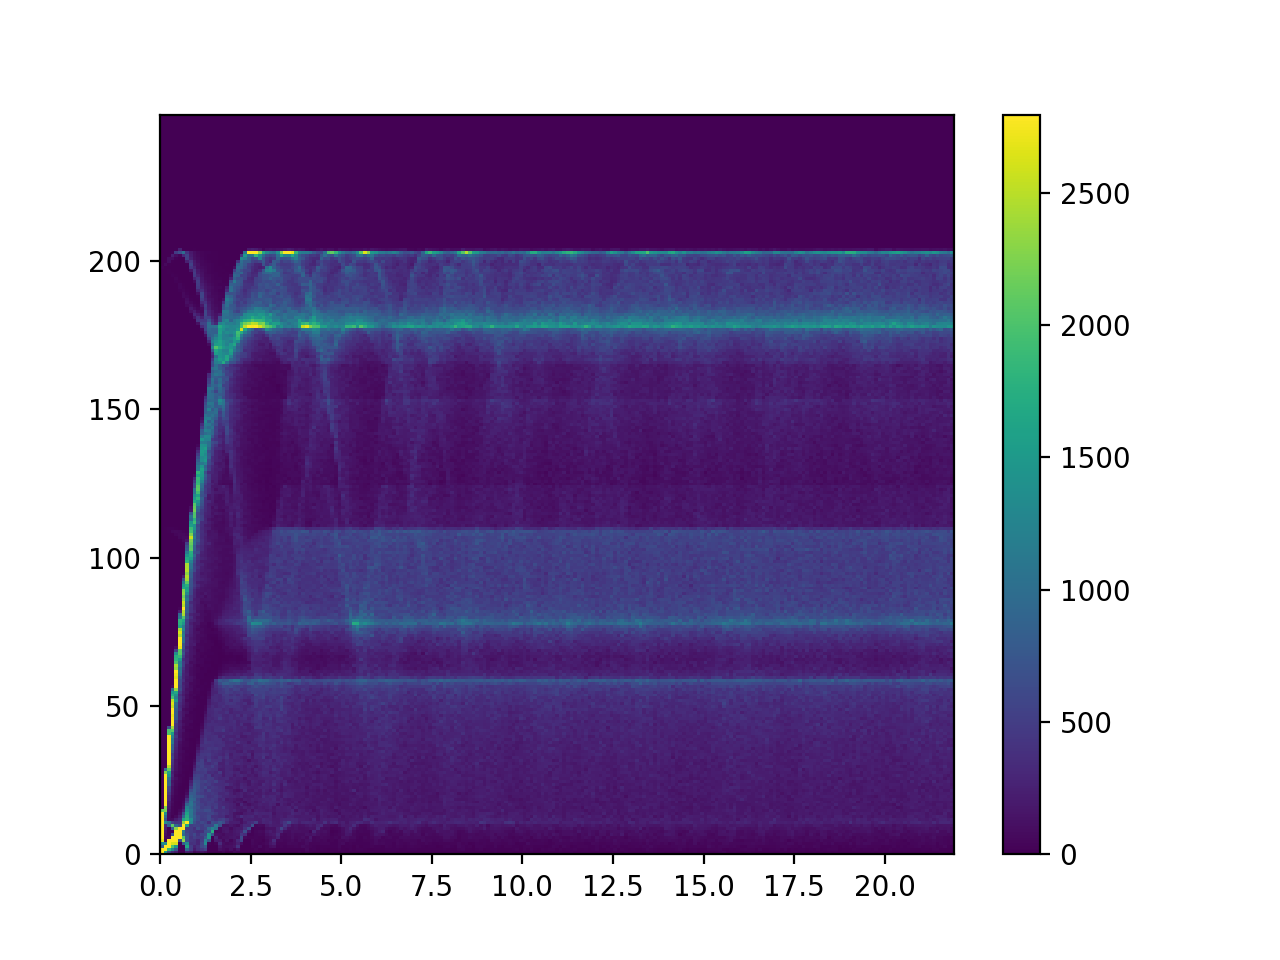

In [69]:
H.plot(IQEhist)